# 영어/한국어 Word2Vec 실습

## 1. 영어 Word2Vec 만들기

### 데이터 로드 및 전처리하기

In [1]:
import re
from lxml import etree
import urllib.request
import zipfile

from nltk.tokenize import word_tokenize, sent_tokenize

In [2]:
urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", 
                           filename="ted_en-20160408.zip")
# 데이터 다운로드

with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
  target_text = etree.parse(z.open('ted_en-20160408.xml', 'r'))
  parse_text = '\n'.join(target_text.xpath('//content/text()'))
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.

In [3]:
parse_text[:300]

"Here are two reasons companies fail: they only do more of the same, or they only do what's new.\nTo me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.\nConsider Facit"

In [4]:
content_text = re.sub(r'\([^)]*\)', '', parse_text)
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.

sent_text=sent_tokenize(content_text)
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.

normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)
# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.

result = [word_tokenize(sentence) for sentence in normalized_text]
# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.

In [5]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [6]:
for line in result[:3]: # 샘플 3개만 출력
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### Word2Vec 훈련시키기

In [7]:
from gensim.models import Word2Vec

In [8]:
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

In [9]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8449841737747192), ('guy', 0.7899907827377319), ('lady', 0.7752558588981628), ('boy', 0.7611932158470154), ('girl', 0.7346731424331665), ('soldier', 0.7148832082748413), ('gentleman', 0.7003980875015259), ('kid', 0.6955503225326538), ('rabbi', 0.6743025779724121), ('poet', 0.6564960479736328)]


### Word2Vec 모델 저장하고 로드하기

In [10]:
from gensim.models import KeyedVectors

In [11]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [13]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8449841737747192), ('guy', 0.7899907827377319), ('lady', 0.7752558588981628), ('boy', 0.7611932158470154), ('girl', 0.7346731424331665), ('soldier', 0.7148832082748413), ('gentleman', 0.7003980875015259), ('kid', 0.6955503225326538), ('rabbi', 0.6743025779724121), ('poet', 0.6564960479736328)]


## 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [12]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt

from konlpy.tag import Okt

from gensim.models.word2vec import Word2Vec

In [14]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fb622663d90>)

In [15]:
train_data = pd.read_table('ratings.txt')

In [16]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [17]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [18]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [19]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [20]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [21]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [22]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [23]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


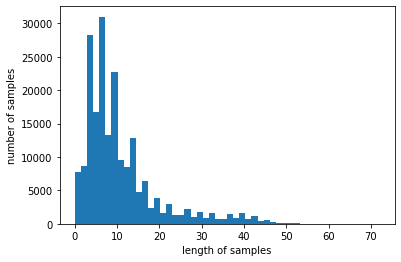

In [25]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
from gensim.models import Word2Vec

In [27]:
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [28]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [29]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8727663159370422), ('김명민', 0.8682565689086914), ('최민수', 0.8590317964553833), ('송강호', 0.8588694334030151), ('서영희', 0.8575315475463867), ('정재영', 0.8535062074661255), ('조재현', 0.8512427806854248), ('메릴', 0.8477133512496948), ('설경구', 0.8471947908401489), ('안성기', 0.8466501832008362)]


In [30]:
print(model.wv.most_similar("히어로"))

[('무협', 0.8951178193092346), ('호러', 0.8802809715270996), ('느와르', 0.8760687112808228), ('슬래셔', 0.8674249649047852), ('물의', 0.8446604013442993), ('블록버스터', 0.8432347774505615), ('물', 0.8343549966812134), ('멜로', 0.8216524124145508), ('판타지', 0.8197519183158875), ('무비', 0.8192780017852783)]


## 한국어 Word2Vec 만들기(위키피디아)

https://dumps.wikimedia.org/kowiki/latest/

그 중에서 사용할 데이터는 kowiki-latest-pages-articles.xml.bz2 파일입니다. 해당 파일은 xml 파일므로, Word2Vec을 원활하게 진행하기 위해 파일 형식을 변환해줄 필요가 있습니다.

### 위키피디아 익스트랙터 다운로드

git clone "https://github.com/attardi/wikiextractor.git"  

위키피디아 한국어 덤프 파일 변환

위키피디아 익스트랙터와 위키피디아 한국어 덤프 파일을 동일한 디렉토리 경로에 두고, 아래 명령어를 실행하면 위키피디아 덤프 파일이 텍스트 파일로 변환됩니다. 컴퓨터마다 다르지만 보통 10분 내외의 시간이 걸립니다.

python WikiExtractor.py kowiki-latest-pages-articles.xml.bz2  

텍스트 파일로 변환된 위키피디아 한국어 덤프는 총 6개의 디렉토리(2018년 10월 기준)로 구성되어져 있습니다. AA ~ AF의 디렉토리로 각 디렉토리 내에는 wiki_00 ~ wiki_90이라는 파일들이 들어있습니다. 각 파일들을 열어보면 이와 같은 구성이 반복되고 있습니다.

이제 이 6개 AA ~ AF 디렉토리 안의 wiki00 ~ wiki90 파일들을 하나의 텍스트 파일로 통합하겠습니다. (만약, 더 간단히 하고 싶다면 모든 디렉토리 파일을 통합하지 않고, 하나의 디렉토리 내의 파일들에 대해서만 통합 작업을 진행하고 모델의 입력으로 사용할수도있습니다. 하지만 모델의 성능은 전체 파일에 대해서 진행한 경우보다 좋지 않을 수 있습니다.)

작업은 6개의 디렉토리 내 파일들에 대해서 각 하나의 파일로 통합 후, 6개의 파일을 다시 하나로 통합하는 순서로 진행합니다.

### 훈련 데이터 만들기

우선 AA 디렉토리 안의 모든 파일인 wiki00 ~ wiki90에 대해서 wikiAA.txt로 통합해보겠습니다. 프롬프트에서 아래의 커맨드를 수행합니다. (윈도우 환경 기준)

copy AA디렉토리의 경로\wiki* wikiAA.txt

해당 커맨드는 AA디렉토리 안의 wiki로 시작되는 모든 파일을 wikiAA.txt 파일에 전부 복사하라는 의미를 담고있습니다. 결과적으로 wiki00 ~ wiki90파일의 모든 내용은 wikiAA.txt 파일이라는 하나의 파일에 내용이 들어가게 됩니다.

각 디렉토리에 대해서도 동일하게 진행합니다.

copy AB디렉토리의 경로\wiki* wikiAB.txt
copy AC디렉토리의 경로\wiki* wikiAC.txt
copy AD디렉토리의 경로\wiki* wikiAD.txt
copy AE디렉토리의 경로\wiki* wikiAE.txt
copy AF디렉토리의 경로\wiki* wikiAF.txt

이렇게 되면 현재 경로에는 각 디렉토리의 파일들을 하나로 합친 wikiAA.txt 부터 wikiAF.txt라는 6개의 파일이 생깁니다. 그럼 이제 이 파일들에 대해서도 하나의 파일로 합치는 작업을 진행해보겠습니다.

copy 현재 디렉토리의 경로\wikiA* wiki_data.txt

이제 모든 텍스트 파일을 하나로 만든 훈련 데이터가 완성되었습니다.

### 훈련 데이터 전처리 하기

In [ ]:
f = open('wiki_data.txt 파일의 경로', encoding="utf8")
# 예를 들어 위도우 바탕화면에서 작업한 저자의 경우
# f = open(r'C:\Users\USER\Desktop\wiki_data.txt', encoding="utf8")

In [ ]:
i=0
while True:
    line = f.readline()
    if line != '\n':
        i=i+1
        print("%d번째 줄 :"%i + line)
    if i==5:
        break 
f.close()

In [ ]:
from konlpy.tag import Okt  

In [ ]:
okt=Okt()
fread = open('wiki_data.txt 파일의 경로', encoding="utf8")
# 파일을 다시 처음부터 읽음.
n=0
result = []

while True:
    line = fread.readline() #한 줄씩 읽음.
    if not line: break # 모두 읽으면 while문 종료.
    n=n+1
    if n%5000==0: # 5,000의 배수로 While문이 실행될 때마다 몇 번째 While문 실행인지 출력.
        print("%d번째 While문."%n)
    tokenlist = okt.pos(line, stem=True, norm=True) # 단어 토큰화
    temp=[]
    for word in tokenlist:
        if word[1] in ["Noun"]: # 명사일 때만
            temp.append((word[0])) # 해당 단어를 저장함

    if temp: # 만약 이번에 읽은 데이터에 명사가 존재할 경우에만
      result.append(temp) # 결과에 저장
fread.close()

In [ ]:
print('총 샘플의 개수 : {}'.format(len(result))

### Word2Vec 훈련시키기

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(result, size=100, window=5, min_count=5, workers=4, sg=0)

In [ ]:
model_result1 = model.wv.most_similar("대한민국")
print(model_result1)

In [ ]:
model_result2 = model.wv.most_similar("어벤져스")
print(model_result2)

In [ ]:
model_result3 = model.wv.most_similar("반도체")
print(model_result3)

## 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

### 영어

모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [31]:
import gensim

In [32]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [33]:
print(model.vectors.shape) # 모델의 크기 확인

(3000000, 300)


In [34]:
print (model.similarity('this', 'is')) # 두 단어의 유사도 계산하기
print (model.similarity('post', 'book'))

0.40797037
0.057204384


In [35]:
print(model['book']) # 단어 'book'의 벡터 출력

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

### 한국어

모델 다운로드 경로 : https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view

In [36]:
import gensim

In [37]:
model = gensim.models.Word2Vec.load('ko/ko.bin')

In [38]:
result = model.wv.most_similar("강아지")
print(result)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


In [40]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import backend as K

sess = tf.Session()
K.set_session(sess)
# 세션 초기화. 이는 텐서플로우 개념.

elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)
# 텐서플로우 허브로부터 ELMo를 다운로드

sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

AttributeError: module 'tensorflow' has no attribute 'Session'

In [41]:
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

2020-04-12 06:01:35,674 - word2vec2tensor - INFO - running /Users/wolee-mac/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/gensim/scripts/word2vec2tensor.py --input eng_w2v --output eng_w2v
2020-04-12 06:01:35,674 - utils_any2vec - INFO - loading projection weights from eng_w2v
2020-04-12 06:01:37,333 - utils_any2vec - INFO - loaded (21613, 100) matrix from eng_w2v
2020-04-12 06:01:38,761 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2020-04-12 06:01:38,761 - word2vec2tensor - INFO - Tensor metadata file saved to eng_w2v_metadata.tsv
2020-04-12 06:01:38,763 - word2vec2tensor - INFO - finished running word2vec2tensor.py
